# Alex AI/ML Training V3

Testing approach from https://www.sciencedirect.com/science/article/pii/S0021929018304354
Estimation of vertical ground reaction force during running using neural network model and uniaxial accelerometer



In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2024-12-02 13:34:12.460393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 13:34:12.469294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733139252.479755 1738404 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733139252.482904 1738404 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 13:34:12.494070: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15958015026811493402
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1299972096
locality {
  bus_id: 1
  links {
  }
}
incarnation: 895050815046136116
physical_device_desc: "device: 0, name: NVIDIA RTX 500 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1733139253.827860 1738404 gpu_device.cc:2022] Created device /device:GPU:0 with 1239 MB memory:  -> device: 0, name: NVIDIA RTX 500 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
#directory path
dir_path = "/home/alexbeat/data/kuopio-gait-dataset-ml"
input_path = f"{dir_path}/_main-input.csv"
output_path = f"{dir_path}/_main-output.csv"

In [4]:
x_og = pd.read_csv(input_path, index_col=0)  # 49 input features
y_og = pd.read_csv(output_path, index_col=0)   # 3 output features (x, y, z)

x_og.drop(columns=['time'], inplace=True)
y_og.drop(columns=['time'], inplace=True)


num_rows = 200000
x = x_og[:num_rows]
y = y_og[:num_rows]

In [5]:
print(x.head())

   pelvis_imu_acc_0  pelvis_imu_acc_1  pelvis_imu_acc_2  tibia_r_imu_acc_0  \
0          9.761505         -0.539103          1.818704          12.697140   
1         10.134969         -0.911804          1.594711          10.897347   
2         10.385214         -1.351347          1.155096           9.525765   
3         10.543116         -1.864298          0.684864           9.072569   
4         10.660259         -2.339200          0.291542           9.549234   

   tibia_r_imu_acc_1  tibia_r_imu_acc_2  femur_r_imu_acc_0  femur_r_imu_acc_1  \
0          16.125368           6.755737           6.553590          -9.642062   
1          16.414892           6.965524           7.794528          -8.131455   
2          14.627335           5.945245           8.543280          -7.183258   
3          11.909804           4.448972           8.545444          -6.877351   
4          10.364927           3.148921           7.764376          -6.626254   

   femur_r_imu_acc_2  tibia_l_imu_acc_0  ...

In [6]:
print(y_og.head())
print(y.head())

       f2_1      f2_2       f2_3
0 -0.678967  0.748046  -7.150059
1 -0.721937  1.238132  -9.194256
2 -0.582924  1.809044 -10.333972
3 -0.132954  2.361078  -9.370096
4  0.781994  2.707438  -4.607854
       f2_1      f2_2       f2_3
0 -0.678967  0.748046  -7.150059
1 -0.721937  1.238132  -9.194256
2 -0.582924  1.809044 -10.333972
3 -0.132954  2.361078  -9.370096
4  0.781994  2.707438  -4.607854


In [31]:
scalerX = StandardScaler()
X = scalerX.fit_transform(x)

Y = y
# scalerY = StandardScaler()
# Y = scalerY.fit_transform(y)
print(f"X shape: {X.shape}")
print(f"Y shape: {y.shape}")

X shape: (200000, 49)
Y shape: (200000, 3)


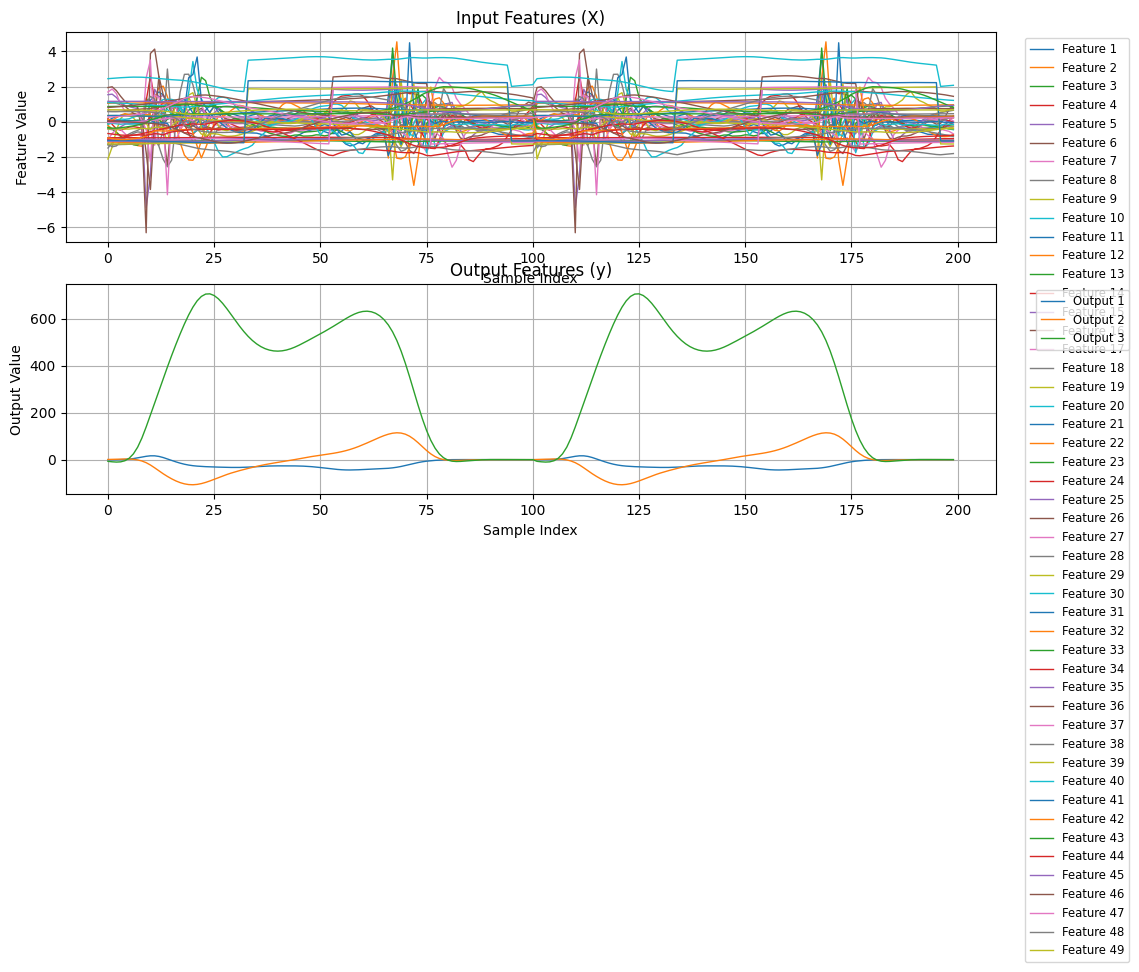

In [37]:
# Create a figure
plt.figure(figsize=(12, 6))

graph_window = 200
# Plotting the input features (X)
plt.subplot(2, 1, 1)
for i in range(X.shape[1]):  # Loop through each feature (column)
    plt.plot(X[:graph_window, i], label=f'Feature {i+1}', linewidth=1)
plt.title('Input Features (X)')
plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')
plt.grid()

# Plotting the output features (y)
plt.subplot(2, 1, 2)
for i in range(Y.shape[1]):  # Loop through each output feature (column)
    plt.plot(Y.iloc[:graph_window, i], label=f'Output {i+1}', linewidth=1)
plt.title('Output Features (y)')
plt.xlabel('Sample Index')
plt.ylabel('Output Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')
plt.grid()

plt.show()

In [34]:
model = Sequential()

model.add(Input(shape=(49,)))  # Using Input layer

# Input layer and first hidden layer
model.add(Dense(256, activation='sigmoid'))

# Second hidden layer
model.add(Dense(512, activation='relu'))

# Output layer
model.add(Dense(3, activation='linear'))  # Linear activation for regression

In [35]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,923 (570.01 KB)

 Trainable params: 145,923 (570.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [36]:
model.fit(X, Y, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 29007.8770 - mae: 94.3040 - val_loss: 13779.8418 - val_mae: 56.6261
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step - loss: 11212.6846 - mae: 50.1440 - val_loss: 12041.8828 - val_mae: 48.2535
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 920us/step - loss: 9618.1719 - mae: 44.4584 - val_loss: 11165.1006 - val_mae: 46.5368
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 920us/step - loss: 8583.0830 - mae: 42.2893 - val_loss: 10622.6123 - val_mae: 44.4815
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 944us/step - loss: 7650.3604 - mae: 40.2421 - val_loss: 10332.7539 - val_mae: 43.7222
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 959us/step - loss: 6970.1401 - mae: 38.4793 - val_loss: 9708.8291 - val_mae: 42.1854
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 933us/step - loss: 6459.2886 - mae: 37.1372 - val_loss: 9391.1660 - val_mae: 40.8570
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 920us/step - loss: 5934.3618 - mae: 35.6

In [49]:
x_text_path = f"{dir_path}/input/01-l_comf_01-input.csv"
y_text_path = f"{dir_path}/output/01-l_comf_01-output.csv"
X_test = pd.read_csv(x_text_path, index_col=0)  # 49 input features
y_test = pd.read_csv(y_text_path, index_col=0)   # 3 output features (x, y, z)
X_test.drop(columns=['time'], inplace=True)
y_test.drop(columns=['time'], inplace=True)

# Normalize test data
X_test = scalerX.transform(X_test)
# y_test = scalerY.transform(y_test)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 81872.6094 - mae: 158.0910  
Test Loss: 68266.1484375, Test MAE: 134.1767578125


In [50]:
predictions = model.predict(X_test)
print(predictions)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
[[-11.044214   10.718785  549.45123  ]
 [-11.220512   10.677353  551.03015  ]
 [-11.183532   11.351889  551.7023   ]
 ...
 [-11.455071    6.480158  357.8465   ]
 [-11.256381    6.360861  364.1749   ]
 [-11.005918    7.1524706 369.64813  ]]


In [51]:
from OneEuroFilter import OneEuroFilter

def apply_one_euro_filter(nd_array, config):
    num_rows, num_cols = nd_array.shape
    filtered_array = np.zeros_like(nd_array)  # Create an array to hold filtered values
    f = OneEuroFilter(**config)
    # Define a helper function to filter a single column
    def filter_column(col_index):
        return np.array([f(nd_array[row, col_index], row) for row in range(num_rows)])

    # Apply the filter to each column using map
    filtered_array = np.column_stack(list(map(filter_column, range(num_cols))))

    return filtered_array

In [52]:
# Iterative way for reference
# from OneEuroFilter import OneEuroFilter

# def apply_one_euro_filter(nd_array, config):
#     num_rows, num_cols = nd_array.shape
#     filtered_array = np.zeros_like(nd_array)  # Create an array to hold filtered values
#     f = OneEuroFilter(**config)
#     for col in range(num_cols):
#         for row in range(num_rows):
#             current_time = row  # Assuming each row corresponds to a time step
#             # First parameter is the value to filter
#             # the second parameter is the current timestamp in seconds
#             filtered_array[row, col] = f(nd_array[row, col], current_time)
#             # filtered_array[row, col] = one_euro_filter.filter(nd_array[row, col], current_time)

#     return filtered_array


In [53]:
# Apply the One Euro Filter to all columns except 'time'
config = {
    'freq': 12,       # Hz
    'mincutoff': 0.001,  # Hz
    'beta': 1.0,       
    'dcutoff': 1.0  
    }
# freq = 12 # Frequency in Hz
# min_cutoff = 0.04
# beta = 0.7
# derivative_cutoff = 1.0
predictions_filtered = apply_one_euro_filter(predictions, config)

# Print the smoothed DataFrame
print(predictions_filtered)

[[-11.044214   10.5363035 549.26685  ]
 [-11.092871   10.669544  551.02594  ]
 [-11.140867   11.255061  551.6912   ]
 ...
 [-11.519062    6.56882   357.71176  ]
 [-11.361141    6.451189  364.01047  ]
 [-11.1191225   7.0009937 369.49503  ]]


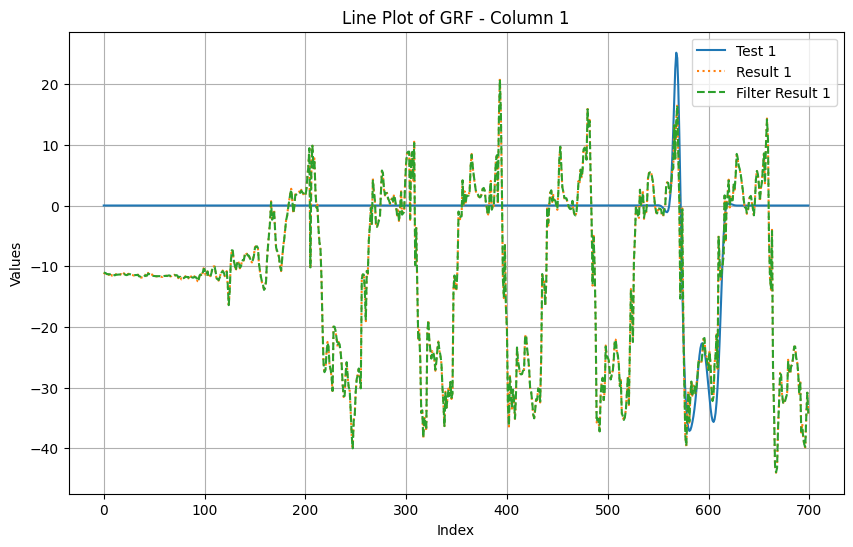

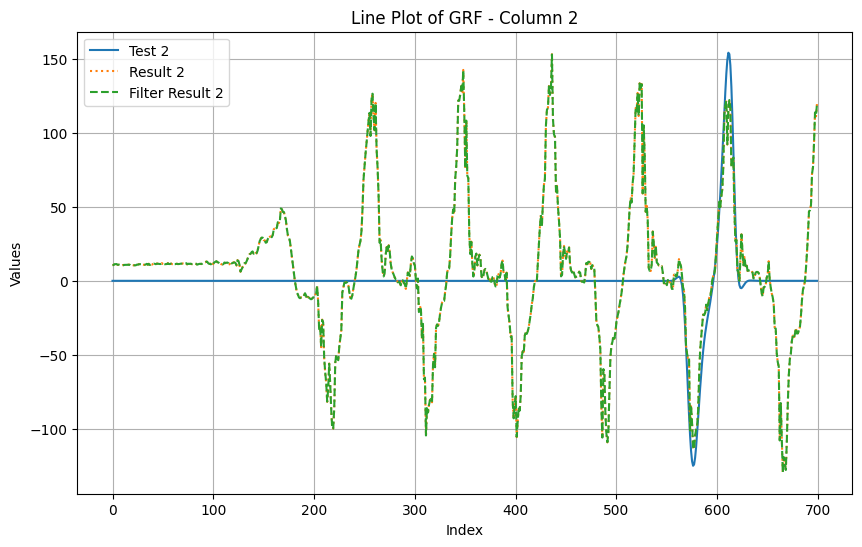

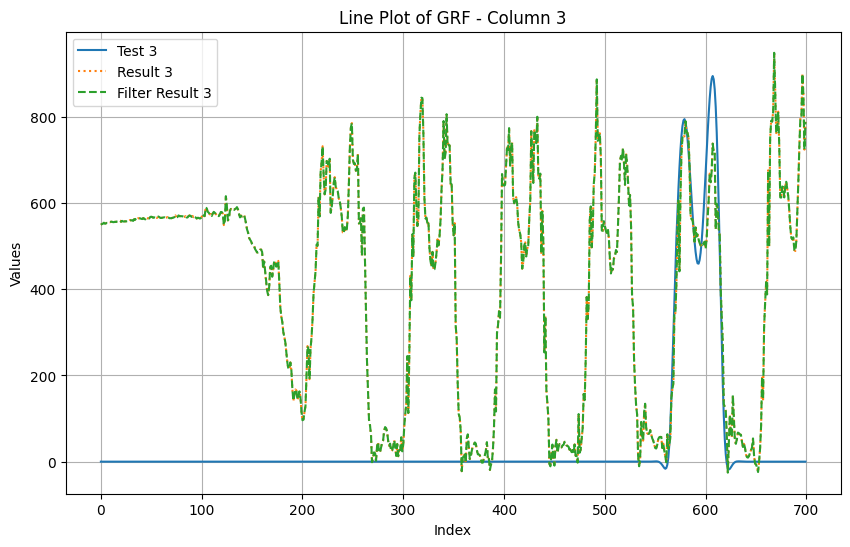

In [59]:
# Assuming y_test and predictions are already defined and are 2D NumPy arrays

min_window = 0
max_window = 700

# Loop over the number of columns
for i in range(y_test.shape[1]):
    plt.figure(figsize=(10, 6))  # Create a new figure for each column
    
    # Plot the test data
    plt.plot(y_test.iloc[min_window:max_window, i], label=f'Test {i+1}')  # Original test data
    
    # Plot the predictions
    plt.plot(predictions[min_window:max_window, i], label=f'Result {i+1}', linestyle=':')  # Predictions
    
    # Optional: Uncomment the next line if you have filtered predictions
    plt.plot(predictions_filtered[min_window:max_window, i], label=f'Filter Result {i+1}', linestyle='--')  # Filtered predictions
    
    # Adding titles and labels
    plt.title(f'Line Plot of GRF - Column {i+1}')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.grid()
    # plt.yscale('log')  # Optional: Use logarithmic scale for better visibility of small values
    
    plt.show()  # Show the figure for the current column

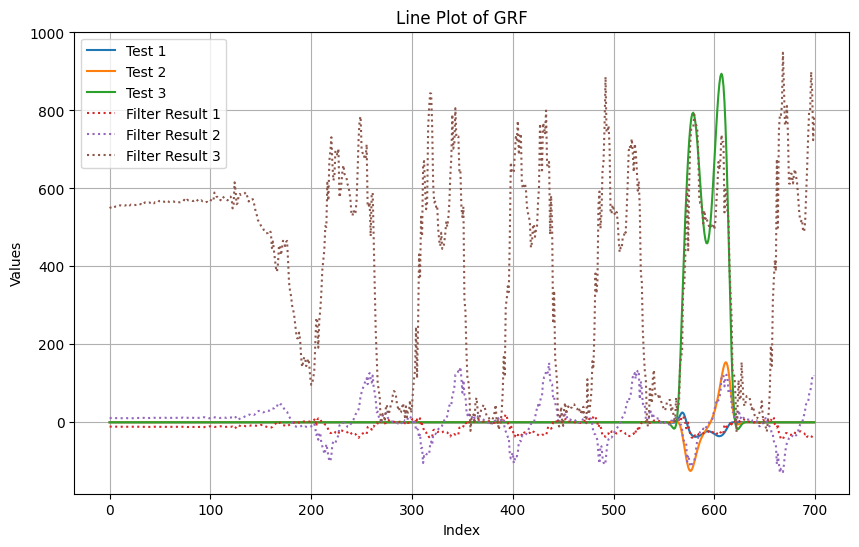

In [60]:
# Plotting the DataFrame
plt.figure(figsize=(10, 6))

for i in range(y_test.shape[1]):  # Loop over the number of columns
    plt.plot(y_test.iloc[min_window:max_window, i], label=f'Test {i+1}')  # Use marker for visibility

# Plot each column as a separate line
for i in range(predictions.shape[1]):  # Loop over the number of columns
    # plt.plot(predictions[min_window:max_window, i], label=f'Result {i+1}', linestyle=':')  # Use marker for visibility
    plt.plot(predictions_filtered[min_window:max_window, i], label=f'Filter Result {i+1}', linestyle=':')  # Use marker for visibility

# Adding titles and labels
plt.title('Line Plot of GRF')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
# plt.yscale('log')  # Optional: Use logarithmic scale for better visibility of small values
plt.show()

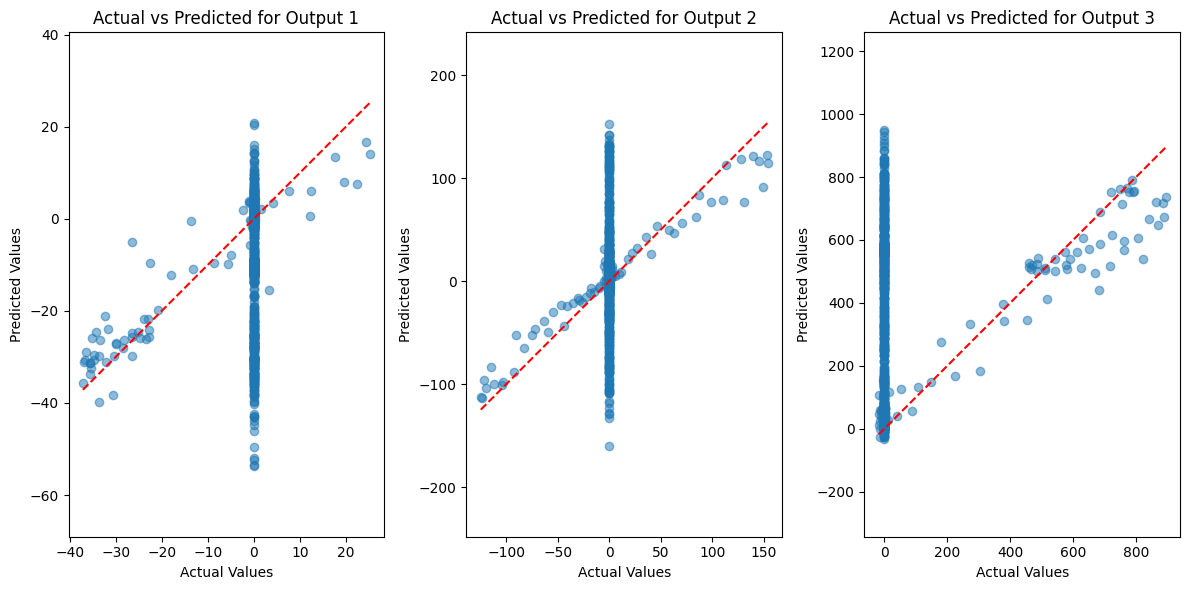

In [61]:
# Create a figure
plt.figure(figsize=(12, 6))
actual_values = y_test
predicted_values = predictions

# Plot actual vs predicted for each output (x, y, z)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(actual_values.iloc[:, i], predicted_values[:, i], alpha=0.5)
    plt.plot([actual_values.iloc[:, i].min(), actual_values.iloc[:, i].max()],
             [actual_values.iloc[:, i].min(), actual_values.iloc[:, i].max()], 'r--')  # Diagonal line
    plt.title(f'Actual vs Predicted for Output {i+1}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.axis('equal')

plt.tight_layout()
plt.show()